# Occupation-skills matrix differentiating between essential and optional skills
Felix Zaussinger | 30.07.2021

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

ESCO data set components

In [52]:
occ = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupations_en.csv"))
skill_groups = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skillGroups_en.csv"))
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))
occ_skills_mapping = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupationSkillRelations.csv"))

### Build occupation - skills matrix

**Encoding**
- 0: skill not required
- 1: skill required, essential
- 2: skill required, optional

In [53]:
errors = 0
skill_vectors = []

for i in tqdm(range(len(occ))):
    occ_uri = occ.iloc[i, :][1]

    # lookup corresponding skills
    skill_list = occ_skills_mapping[occ_skills_mapping["occupationUri"] == occ_uri]

    # create vector
    skill_vector = []
    for j, skill in enumerate(skills.conceptUri.values):

        if skill in skill_list.skillUri.values:
            relation_type = skill_list.loc[skill_list.skillUri == skill, "relationType"].values[0]

            # skill needed for occupation and essential
            if relation_type == "essential":
                skill_vector.append(1)
            # skill needed for occupation and optional
            elif relation_type == "optional":
                skill_vector.append(2)
        else:
            # skill not needed for occupation
            skill_vector.append(0)

    indices = [i for i, j in enumerate(skill_vector) if j == 1]

    # sanity check
    if len(skill_list.skillUri) != np.sum(np.invert(np.array(skill_vector) == 0)):
        errors += 1

    # append
    skill_vectors.append(skill_vector)

# info
print("n_errors: ", errors)

# create df
occ_skills_matrix = pd.DataFrame(
    index=occ.conceptUri,
    columns=skills.conceptUri,
    data=np.array(skill_vectors)
)

100%|██████████| 2942/2942 [12:48<00:00,  3.83it/s]


n_errors:  3


In [59]:
# save
occ_skills_matrix.to_pickle(
    os.path.join(project_dir, "data", "processed", "adjacency_matrix_essential_optional.pkl")
)

In [3]:
occ_skills_matrix = pd.read_pickle(
    os.path.join(project_dir, "data", "processed", "adjacency_matrix_essential_optional.pkl")
)

# weights: essential = 1, optional = 0.5
occ_skills_matrix = occ_skills_matrix.replace(to_replace=2, value=0.5)

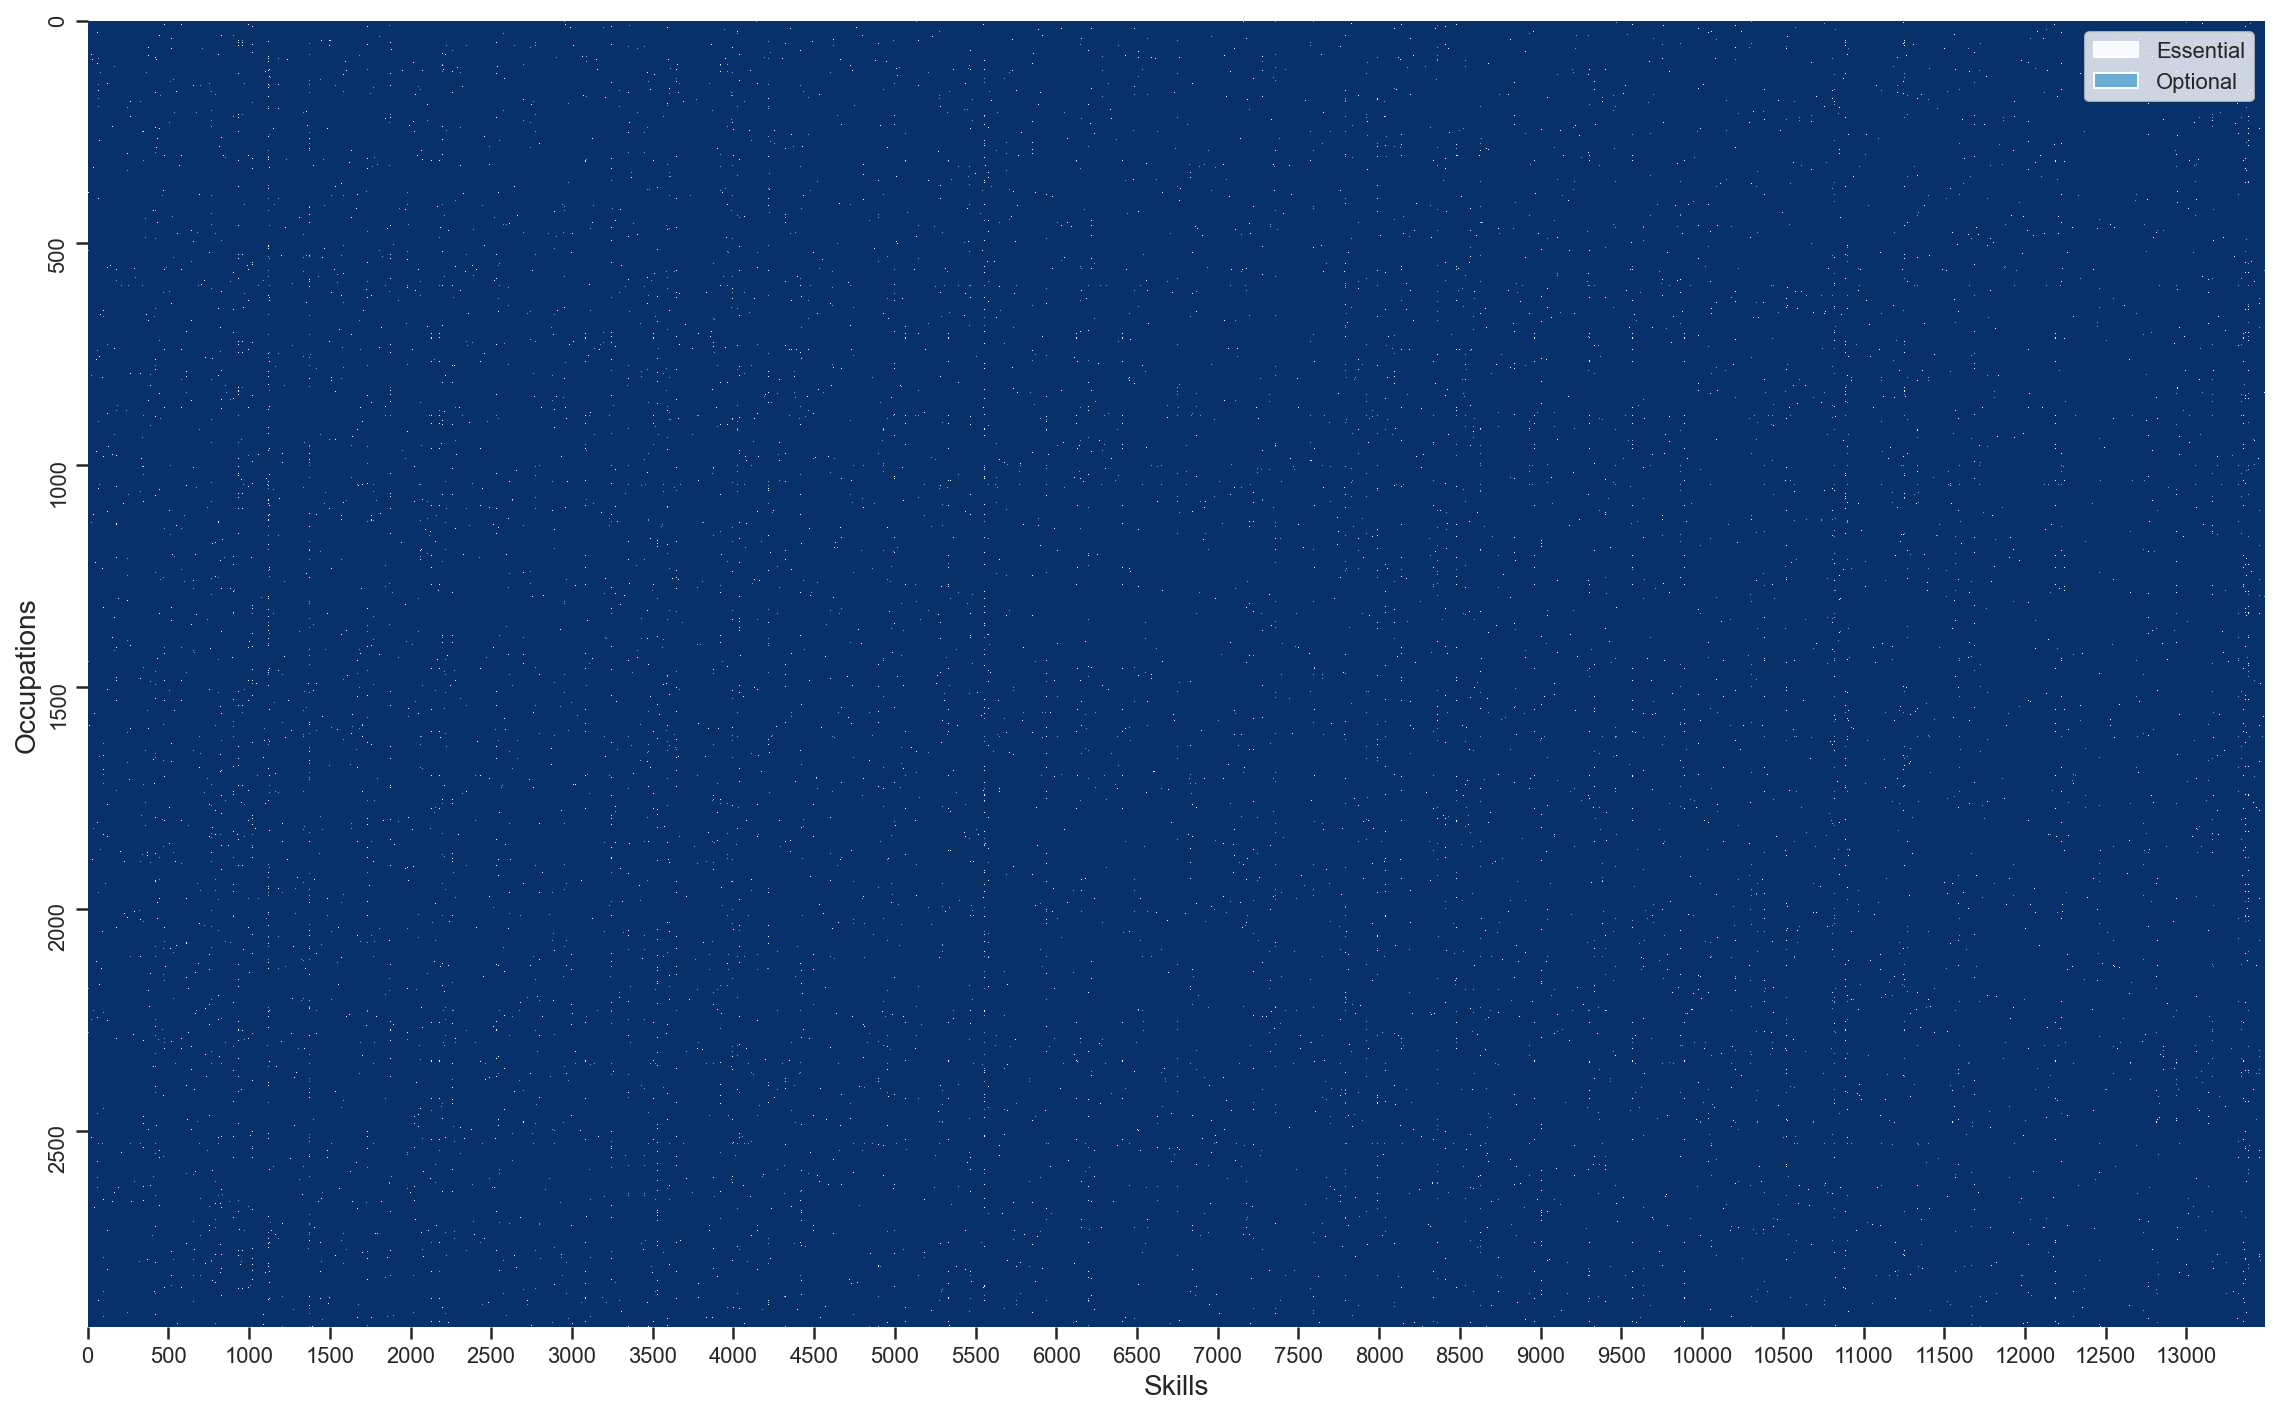

In [24]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(16,10))

cmap = plt.get_cmap('Blues_r', 3)
cmap2 = plt.get_cmap('Blues')

sns.heatmap(
    data=occ_skills_matrix.values,
    cmap=cmap,
    xticklabels=500,
    yticklabels=500,
    ax=ax,
    cbar=False
)

plt.xlabel('Skills', fontsize=14)
plt.ylabel('Occupations', fontsize=14)

legend_elements = [Patch(facecolor=cmap2(1), label='Essential', edgecolor=None),
                   Patch(facecolor=cmap2(0.5), label='Optional', edgecolor=None)]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "esco", "occupation_skills_matrix.png"),
    bbox_inches="tight",
    dpi=150
)

In [24]:
occ_sim_matrix = np.dot(
    occ_skills_matrix.values,
    occ_skills_matrix.values.transpose()
)

In [27]:
df_sim_upeksha = pd.read_csv(
    os.path.join(data_processed, "occupation_adjacency_upeksha.csv"),
    index_col=0
)

In [23]:
sim_kanders = np.load(
    os.path.join(data_raw, "mcc_data", "processed", "sim_matrices", "OccupationSimilarity_Combined.npy")
)

In [33]:
np.corrcoef(occ_sim_matrix.flatten(), df_sim_upeksha.values.flatten())
np.corrcoef(occ_sim_matrix.flatten(), sim_kanders.flatten())

array([[1.        , 0.64141025],
       [0.64141025, 1.        ]])

In [36]:
from scipy.stats import pearsonr

pearsonr(occ_sim_matrix.flatten(), sim_kanders.flatten())

(0.6414102460093973, 0.0)

In [14]:
# the matrices are pretty similar, but not exactly the same
comp = occ_sim_matrix == df_sim_upeksha.values
np.unique(comp, return_counts=True)

(array([False,  True]), array([    932, 8654432]))

In [28]:
occ_sim_matrix.mean()

0.42023238421861864

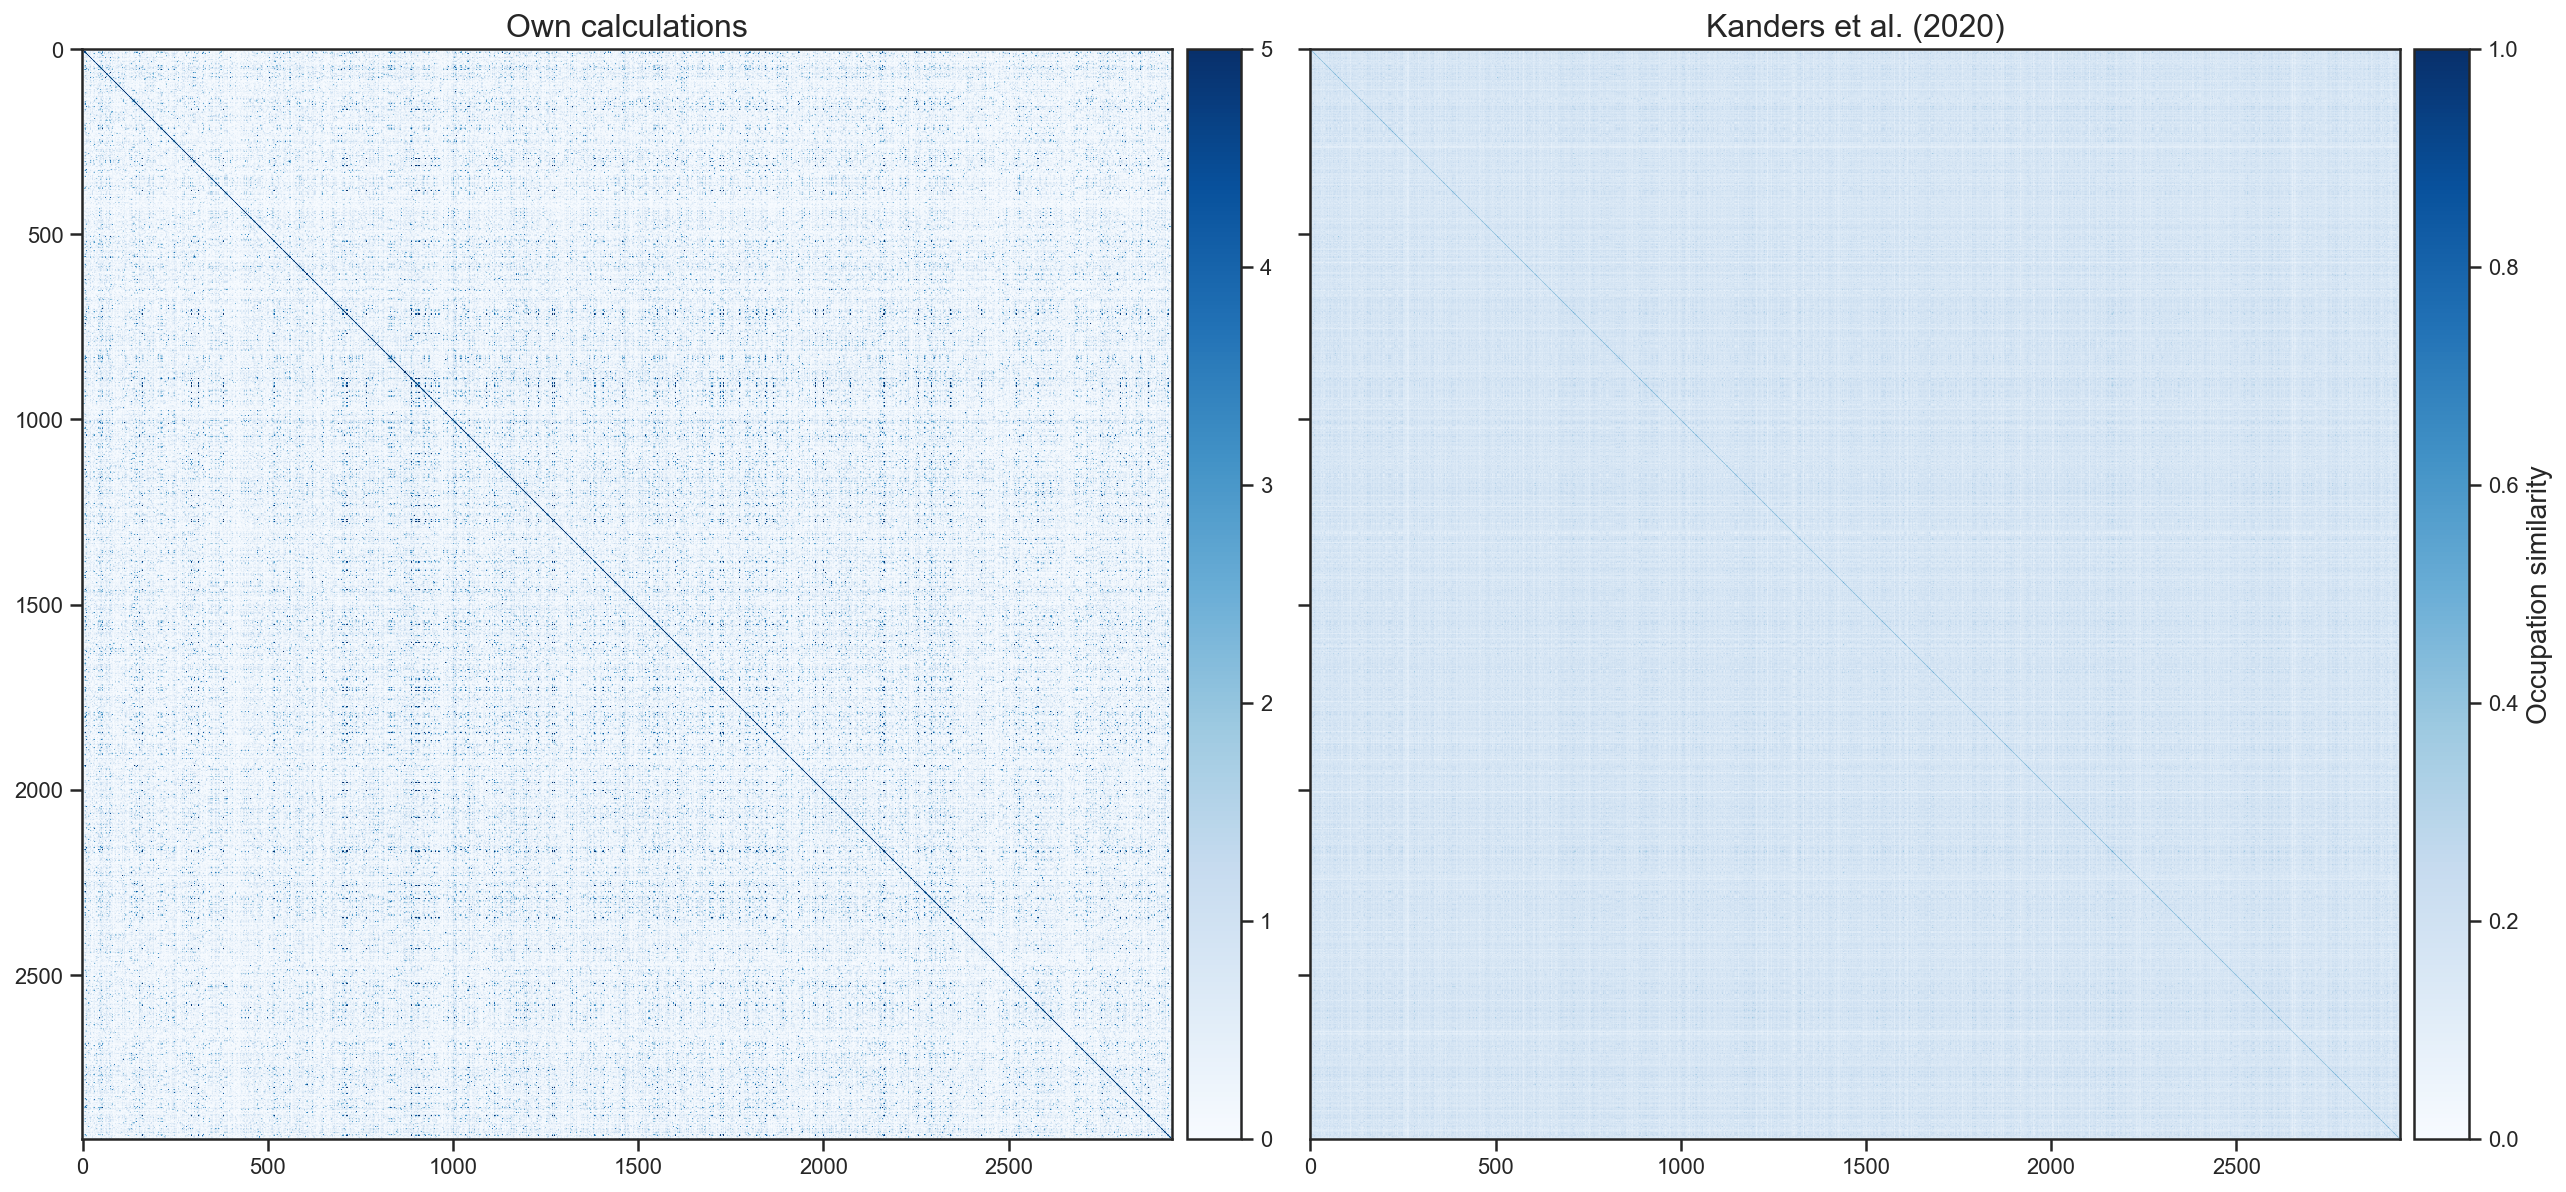

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 9), sharey=True, sharex=True)

# ax1
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.1)

im = ax1.imshow(occ_sim_matrix, cmap = "Blues", vmin=0, vmax=5)
ax1.set_title('Own calculations', fontsize=16)
fig.colorbar(im, cax=cax1, fraction=0.046, pad=0.04, orientation='vertical')

# ax2
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.1)

im = ax2.imshow(sim_kanders, cmap = "Blues", vmin=0, vmax=1)
ax2.set_title('Kanders et al. (2020)', fontsize=16)
fig.colorbar(im, cax=cax2, fraction=0.046, pad=0.04, orientation='vertical')

plt.ylabel('Occupation similarity', fontsize=14)

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "esco", "occupation_similarity_matrix.png"),
    bbox_inches="tight",
    dpi=150
)

### Construct skills similarity matrix
- based on scipy sparse class

In [18]:
from scipy.sparse import csr_matrix

occ_skills_matrix_eo_sparse = csr_matrix(occ_skills_matrix.values)
skill_sim_matrix_eo_sparse = occ_skills_matrix_eo_sparse.transpose().dot(occ_skills_matrix_eo_sparse)
skill_sim_matrix_eo = skill_sim_matrix_eo_sparse.toarray()
skill_sim_matrix_eo.tofile(os.path.join(data_processed, "skill_sim_matrix_eo.npy"))

In [19]:
occ_skills_matrix_unw = occ_skills_matrix.replace(to_replace=0.5, value=1.0)
occ_skills_matrix_unw_sparse = csr_matrix(occ_skills_matrix_unw.values)
skill_sim_matrix_unw_sparse = occ_skills_matrix_unw_sparse.transpose().dot(occ_skills_matrix_unw_sparse)
skill_sim_matrix_unw = skill_sim_matrix_unw_sparse.toarray()
skill_sim_matrix_unw.tofile(os.path.join(data_processed, "skill_sim_matrix.npy"))

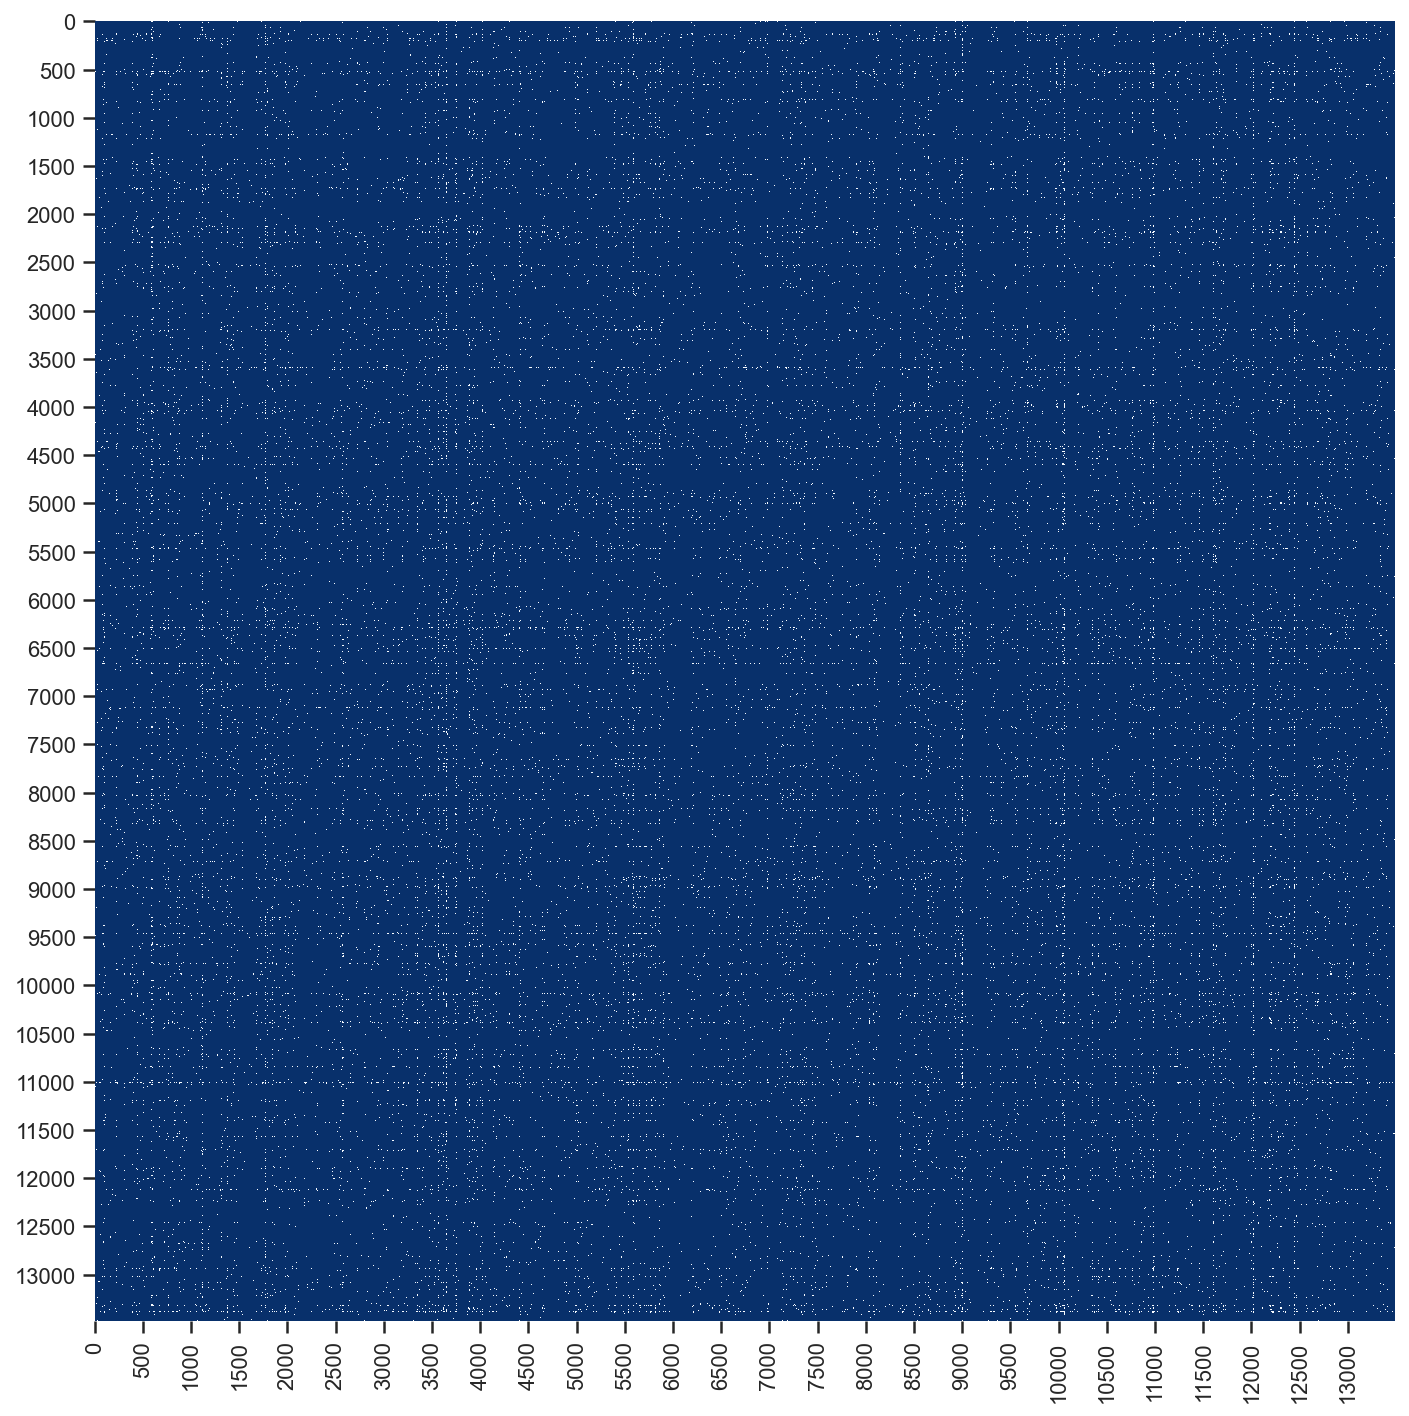

In [37]:
fig, ax = plt.subplots(figsize=(16,10))

cmap = plt.get_cmap('Blues_r')

sns.heatmap(
    data=skill_sim_matrix_unw,
    cmap=cmap,
    xticklabels=500,
    yticklabels=500,
    ax=ax,
    cbar=False,
    vmax=1.,
    square=True
)

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "esco", "skills_skills_matrix.png"),
    bbox_inches="tight",
    dpi=150
)